In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sys
sys.path.append('/Users/CHJ/文稿/weekly_report/CSOM/minisom')
import cmaps
"push test"
'local_main rename test'
# sys.path.append(r'/Users/CHJ/文稿/无人机sar/yamakawa/pi_data/SAR_program')
import SA_func as sa

## 引数定義
ch = 8 # channel
ad_samp_point = 512  # レーダのレンジ方向サンプリング数
az_n = 2000 #アジマス方向のピクセル数
az_dt =0.01
light_speed = sa.light_speed
df = sa.df
dr = sa.dr
ad_samp_point = sa.ad_samp_point
chirp_rate = sa.chirp_rate
d_tau = df / chirp_rate 
dir_name = ""
add_name = ""
filename = "fft_data"

fft_data = sa.read_fft_data(filename)
data = sa.code_V_convert(fft_data) 
raw_data = sa.get_raw_data(data)
index = [700, 1200, 0, 50]
az_s_index = index[0]
az_e_index = index[1]
az_len = az_e_index - az_s_index
rg_s_index = index[2]
rg_e_index = index[3]
rg_len = rg_e_index - rg_s_index
plt.figure(figsize = (12,8))

# # ampを抽出,amp_dataはlog化データ
# data = raw_data[0] #raw_data (8,2000,512)
# amp_data = 20 * np.log10(np.abs(data[az_s_index:az_e_index, rg_s_index:rg_e_index]))
# phase_data = np.angle(data[az_s_index:az_e_index, rg_s_index:rg_e_index])
# amp_phase = np.stack((amp_data, phase_data),axis=-1)
# amp_phase_two_column = np.reshape(amp_phase, (-1, 2))
# "amp_data = np.clip(amp_data, -30, 30) #（500，50）"

''' 8 channelのTX-RX振幅と位相を(500,50,16)に変換'''

# (500,50,2,8)に変換、2の一つのベクトルに8チャンネルのampやphase数値が入っている
amp_phase = []
for i in range(8):
    data = raw_data[i] #raw_data (8,2000,512)
    amp_data = 20 * np.log10(np.abs(data[az_s_index:az_e_index, rg_s_index:rg_e_index]))
    phase_data = np.angle(data[az_s_index:az_e_index, rg_s_index:rg_e_index])
    amp_phase_i = np.stack((amp_data, phase_data),axis=-1)
    amp_phase.append(amp_phase_i)
amp_phase = np.stack(amp_phase, axis=-1)


# # (500,50,8,2)に変換、8チャンネルの一つのベクトルにampとphase数値が入っている
# amp_phase = np.zeros((500, 50, 8, 2))  

# for i in range(8):
#     data = raw_data[i]  # raw_data (8, 2000, 512)
#     amp_data = 20 * np.log10(np.abs(data[az_s_index:az_e_index, rg_s_index:rg_e_index]))
#     phase_data = np.angle(data[az_s_index:az_e_index, rg_s_index:rg_e_index])
#     amp_phase_i = np.stack((amp_data, phase_data), axis=-1)
#     amp_phase[:, :, i, :] = amp_phase_i  


amp_phase_16_column = np.reshape(amp_phase, (-1, 16))
# amp_phase_16_column = np.reshape(amp_phase, (-1, 8, 2))

# #sar_data
# all_sar_data = np.zeros(((index[1] - index[0]), (index[3] - index[2])), dtype = np.complex64)
# all_sar_data = sa.back_projection(raw_data, index, conv_az_n, spline_d_array)


# target_amp_data = 20 * np.log10(np.abs(data[900:1000, 12:16]))
# target_phase_data = np.angle(data[900:1000, 12:16])
# target_data= np.hstack((target_amp_data, target_phase_data))
# target_two_column = np.reshape(target_data, (-1, 2))

# # 绘制散点图
# plt.scatter(amp_phase_two_column[:,0], amp_phase_two_column[:,1], s=75, c='purple', alpha=0.5)
# plt.scatter(target_two_column[:,0], target_two_column[:,1], s=75, c='red', alpha=0.5)

# # 添加标题和标签
# plt.title('Scatter Plot')
# plt.xlabel('amp')
# plt.ylabel('phase')

<Figure size 1200x800 with 0 Axes>

['/Users/CHJ/文稿/weekly_report/CSOM/minisom', '/Users/CHJ/文稿/weekly_report/CSOM', '/Users/CHJ/miniforge3/envs/practice/lib/python39.zip', '/Users/CHJ/miniforge3/envs/practice/lib/python3.9', '/Users/CHJ/miniforge3/envs/practice/lib/python3.9/lib-dynload', '', '/Users/CHJ/miniforge3/envs/practice/lib/python3.9/site-packages', '/Users/CHJ/文稿/weekly_report/CSOM/minisom']
training...
 [ 250000 / 250000 ] 100% - 0:00:00 left 
 quantization error: 13.272938908716728
quantization...
building new image...


/Users/CHJ/文稿/weekly_report/CSOM/minisom/minisom_ring.py:432: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


Class 1 :
[28.8194809  32.32994461 30.82579803 37.05110168 28.70547295 31.62509918
 33.45020676 28.24666214 -0.23936096 -3.00785136 -0.47632572  0.99796075
 -0.48381558  2.78093314 -0.12569824  0.82101345]
Class 2 :
[13.35078144 16.58925819 12.69338989 12.74012661  8.44166088 10.34322929
  8.26533222  5.03580523 -2.15090489  0.99120849 -2.44505882 -2.85661149
  1.48366451 -1.21528029  1.89840269  3.10260487]
Class 3 :
[ 2.04128113e+01  2.25949631e+01  2.13499622e+01  2.38048019e+01
  1.46722374e+01  1.81201839e+01  1.96755085e+01  1.53335648e+01
 -1.27804554e+00  2.14827490e+00 -1.56019795e+00  2.37710355e-03
 -1.25715792e+00  1.66006052e+00 -9.53859866e-01 -3.64541002e-02]
Class 4 :
[18.23033524 20.23643494 18.77729034 18.63182259  3.82348299 14.62815762
 10.81332588  7.84176302 -1.7015326   1.58557034 -1.94849193 -0.81126738
 -1.92679679  0.7582674  -2.33296061 -1.02243066]
Class 5 :
[13.30747604 16.00063705 12.6030674  11.57360935  6.46433926 11.07722187
 10.72145939  4.98010063 -2.

Text(0.5, 1.0, 'Clustering Result')

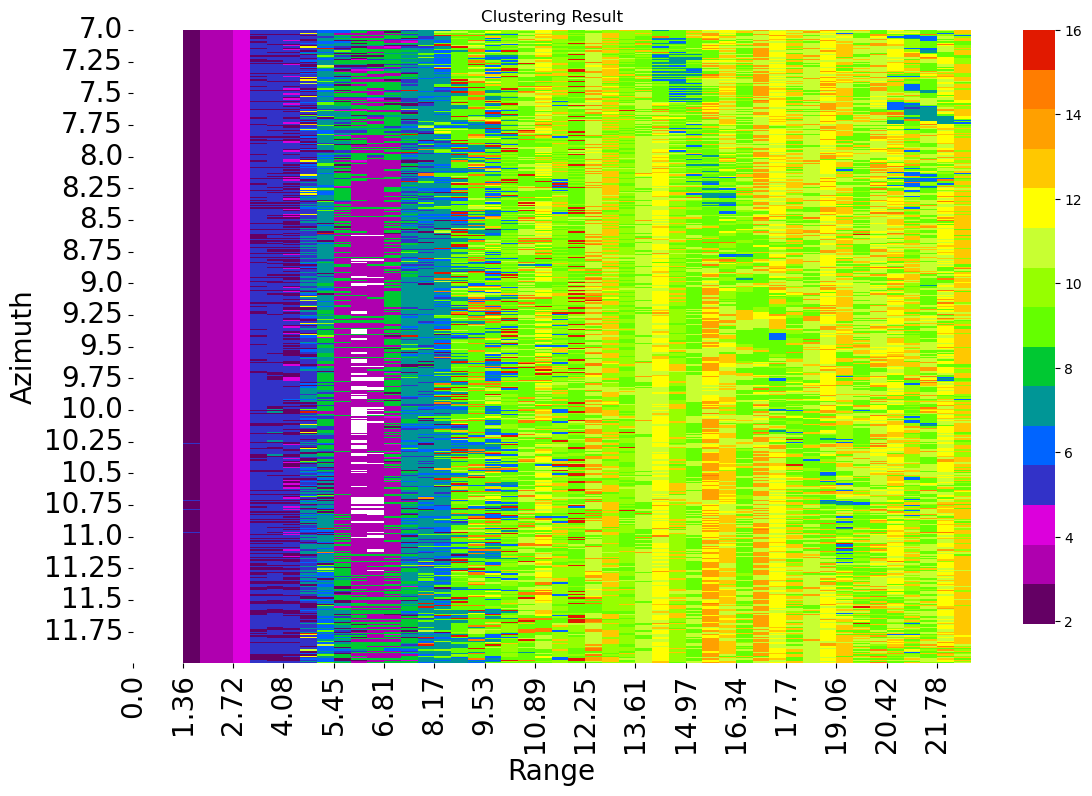

In [2]:
import sys
sys.path.insert(0,'/Users/CHJ/文稿/weekly_report/CSOM/minisom') # when the module name is same as built-in module, can not use from ... import ...
print(sys.path)
import minisom_ring

# # read the image
# img = plt.imread('tree.jpg')

# # reshaping the pixels matrix
# pixels = np.reshape(img, (img.shape[0]*img.shape[1], 1))
pixels = amp_phase_16_column

# SOM initialization and training
print('training...')
som = minisom_ring.MiniSom_ring(16, 16, sigma=2.,
              learning_rate=0.9, neighborhood_function='bubble')  
som.random_weights_init(pixels)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train_ring(pixels, 10, random_order=True, verbose=True, use_epochs=True)

print('quantization...')
qnt = som.quantization(pixels)  # quantize each pixels of the image
print('building new image...')
clustered = np.zeros((*amp_data.shape, 16), dtype=np.float64)
for i, q in enumerate(qnt):  # place the quantized values into a new image
    clustered[np.unravel_index(i, shape=(amp_data.shape[0], amp_data.shape[1]))] = q
labelled = np.zeros((*amp_data.shape, 1), dtype=np.float64)
flattened = clustered.reshape(-1, clustered.shape[-1])

# 初始化类别标号
class_labels = np.zeros((flattened.shape[0],), dtype=int)
current_label = 1

# 遍历每个向量
for i, vector in enumerate(flattened):
    # 如果已经被分为类别，则跳过
    if class_labels[i] != 0:
        continue
    
    # 将当前向量标记为当前类别
    class_labels[i] = current_label
    
    # 查找与当前向量完全相同的向量，并标记为相同类别
    for j in range(i+1, flattened.shape[0]):
        if np.array_equal(vector, flattened[j]):
            class_labels[j] = current_label
    
    # 增加类别标号
    current_label += 1

    # 各ラベルに対応するベクトルを取得
for i in range(1, 17):
    print("Class", i, ":")
    for j in range(len(class_labels)):
        if class_labels[j] == i:
            print(flattened[j])
            break

# 将类别标号重新整形回与clustered相同的形状
class_labels = class_labels.reshape(clustered.shape[:-1])


print('done.')


# # amp heatmap
# for i in range(8):
#     all_font = 20
#     plt.figure(figsize=(12, 8))
#     sns.heatmap(clustered[:,:,i], cmap="precip2_15lev",vmin = -30, vmax = 30) # amp image, 0-7
#     name = ["", "range [m]", "azimuth [s]"]
#     dx = d_tau * light_speed / 2 / 2
#     dy = 0.01
#     x_step = int(rg_len / 25) + 1
#     y_step = int(az_len / 20)
#     plt.xticks(np.arange(0, rg_e_index - rg_s_index, step = x_step), np.round(np.arange(rg_s_index * dx, rg_e_index * dx, step = dx * x_step), 2), fontsize = all_font, rotation = 90)
#     plt.yticks(np.arange(0, az_e_index - az_s_index, step = y_step), np.round(np.arange(az_s_index * dy, az_e_index * dy, step = dy * y_step), 2), fontsize = all_font)
#     plt.title(name[0])
#     plt.xlabel(name[1], fontsize = all_font)
#     plt.ylabel(name[2], fontsize = all_font)
#     plt.tight_layout()
#     plt.xlabel("Range")
#     plt.ylabel("Azimuth")
#     plt.title("Clustering Result")
#     plt.savefig('amp_' +str(i)+ ".pdf", format = "pdf", bbox_inches = 'tight')

# # phase heatmap
# for j in range(8,16,1):
#     all_font = 20
#     plt.figure(figsize=(12, 8))
#     my_cmap = cm.get_cmap('precip2_15lev')
#     my_cmap.set_under('w')
#     sns.heatmap(class_labels[:,:,j], cmap=my_cmap) # phase image, 8-15
#     name = ["", "range [m]", "azimuth [s]"]
#     dx = d_tau * light_speed / 2 / 2
#     dy = 0.01
#     x_step = int(rg_len / 25) + 1
#     y_step = int(az_len / 20)
#     plt.xticks(np.arange(0, rg_e_index - rg_s_index, step = x_step), np.round(np.arange(rg_s_index * dx, rg_e_index * dx, step = dx * x_step), 2), fontsize = all_font, rotation = 90)
#     plt.yticks(np.arange(0, az_e_index - az_s_index, step = y_step), np.round(np.arange(az_s_index * dy, az_e_index * dy, step = dy * y_step), 2), fontsize = all_font)
#     plt.title(name[0])
#     plt.xlabel(name[1], fontsize = all_font)
#     plt.ylabel(name[2], fontsize = all_font)
#     plt.tight_layout()
#     plt.xlabel("Range")
#     plt.ylabel("Azimuth")
#     plt.title("Clustering Result")  
#     plt.savefig('phase_' +str(j)+ ".pdf", format = "pdf", bbox_inches = 'tight')

all_font = 20
plt.figure(figsize=(12, 8))
# my_cmap = cmaps.precip2_15lev
# my_cmap.set_under('w')
sns.heatmap(class_labels, cmap=cmaps.precip2_15lev) 
name = ["", "range [m]", "azimuth [s]"]
dx = d_tau * light_speed / 2 / 2
dy = 0.01
x_step = int(rg_len / 25) + 1
y_step = int(az_len / 20)
plt.xticks(np.arange(0, rg_e_index - rg_s_index, step = x_step), np.round(np.arange(rg_s_index * dx, rg_e_index * dx, step = dx * x_step), 2), fontsize = all_font, rotation = 90)
plt.yticks(np.arange(0, az_e_index - az_s_index, step = y_step), np.round(np.arange(az_s_index * dy, az_e_index * dy, step = dy * y_step), 2), fontsize = all_font)
plt.title(name[0])
plt.xlabel(name[1], fontsize = all_font)
plt.ylabel(name[2], fontsize = all_font)
plt.tight_layout()
plt.xlabel("Range")
plt.ylabel("Azimuth")
plt.title("Clustering Result")

